##### Copyright 2024 The AI Edge LiteRT Authors.

In [2]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

End-to-end Example to show how a pre-trained FLAX model can be downloaded, exported and ran.
===============
1. The model used is Resnet50, downloaded from huggingface pre-trained models
2. Test image is of a CAT
3. `orbax-export` API is used to export the JAX Module to a TF Saved Model, along with image pre/post-processing functions.
4. TFLite Converter & Runtime are used to convert the TF Saved Model to .tflite and run on the test image.


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/examples/jax_conversion/jax_to_tflite_resnet50"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-ai-edge/LiteRT/blob/main/tests/jax_conversion/jax_to_tflite_resnet50.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google-ai-edge/LiteRT/blob/main/tests/jax_conversion/jax_to_tflite_resnet50.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://github.com/google-ai-edge/LiteRT/blob/main/tests/jax_conversion/jax_to_tflite_resnet50.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Setup

In [3]:
!pip install orbax-export

!pip install tf-nightly

!pip install --upgrade jax jaxlib

!pip install transformers flax

## Show Test Image

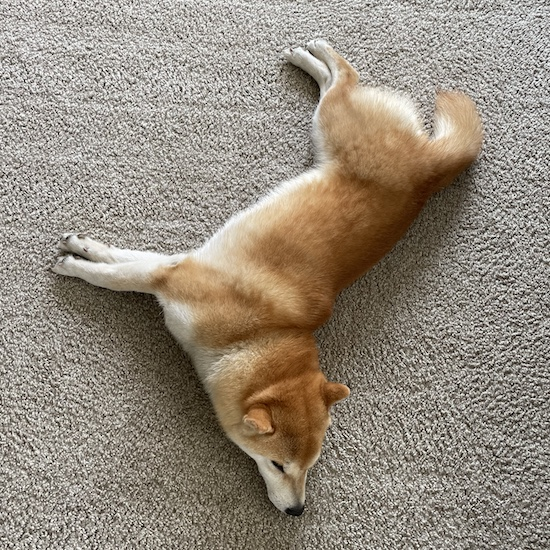

In [4]:
from PIL import Image
import jax
import requests

url = "https://storage.googleapis.com/download.tensorflow.org/example_images/astrid_l_shaped.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

## Download and test pre-trained Resnet50 FLAX model from HuggingFace

In [5]:
from transformers import ConvNextImageProcessor, FlaxResNetForImageClassification

image_processor = ConvNextImageProcessor.from_pretrained("microsoft/resnet-50")
model = FlaxResNetForImageClassification.from_pretrained("microsoft/resnet-50")

inputs = image_processor(images=image, return_tensors="np")
outputs = model(**inputs)
logits = outputs.logits

# model predicts one of the 1000 ImageNet classes
predicted_class_idx = jax.numpy.argmax(logits, axis=-1)
print("Predicted class:", model.config.id2label[predicted_class_idx.item()])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Predicted class: Pembroke, Pembroke Welsh corgi


# Create a JAX wrapper for the model
Wrapper is needed in order to comply with TFLite accepts inputs. TFLite accets a tensor or a tuple-of-tensors.

In [6]:
import flax.linen as nn
from transformers import FlaxResNetForImageClassification


class Resnet50Wrapper(nn.Module):
  pretrained_model_name: str = "microsoft/resnet-50"  # Pre-trained model name

  def setup(self):
    # Initialize the pre-trained ResNet50 model
    self.model = FlaxResNetForImageClassification.from_pretrained(
        self.pretrained_model_name
    )

  def __call__(self, inputs):
    # Process input images through the ResNet50 model
    outputs = self.model(pixel_values=inputs)

    # Return logits or directly apply softmax for probabilities (optional)
    return outputs.logits

## Tensorflow image pre-processor function
This essentialliy implements the underlying logic of the `ConvNextImageProcessor` class in huggingface transformers:
> ```
> image_processor = ConvNextImageProcessor.from_pretrained("microsoft/resnet-50")
> inputs = image_processor(images=image, return_tensors="np")
> ```

This utility can be reused later during orbax-export for `tf_preprocessing`.

Note: We can perfectly use the result of `ConvNextImageProcessor` to run a TFLite model. But this example would like to showcase how `orbax-export` helps handle input/output pre/post-processing.

In [7]:
import tensorflow as tf
import numpy as np


def resnet_image_processor(image_tensor):
  # 1. Resize and Cast to Float32
  image_resized = tf.image.resize(
      image_tensor, (224, 224), method=tf.image.ResizeMethod.BILINEAR
  )
  image_float = tf.cast(image_resized, tf.float32)

  # 2. Normalize (Using TensorFlow Constants)
  mean = tf.constant([0.485, 0.456, 0.406])
  std = tf.constant([0.229, 0.224, 0.225])
  image_normalized = (image_float / 255.0 - mean) / std

  # 3. Transpose for Channel-First Format
  image_transposed = tf.transpose(image_normalized, perm=[2, 0, 1])

  # 4. Add Batch Dimension
  return tf.expand_dims(image_transposed, axis=0)

## Initialize the Jax model

In [8]:
# Initialize the JAX Model
jax_model = Resnet50Wrapper()

## Validate the wrapped JAX Model

In [9]:
# Convert the raw image values to RGB tensor
raw_image_tensor = tf.convert_to_tensor(np.array(image, dtype=np.float32))

# Appy the above TF imape preprocessing to get an input tensor supported by Resnet50
input_tensor = resnet_image_processor(raw_image_tensor)

# Run the JAX model
jax_logits = jax_model.apply({}, input_tensor.numpy())

jax_predicted_class_idx = jax.numpy.argmax(jax_logits, axis=-1)
print("Predicted class:", model.config.id2label[jax_predicted_class_idx.item()])

Predicted class: dingo, warrigal, warragal, Canis dingo


In [10]:
raw_image_tensor.shape

TensorShape([550, 550, 3])

# Export to TFLite model and run

## Export the JAX to TF Saved Model using orbax-export

In [11]:
from orbax.export import ExportManager, JaxModule, ServingConfig

# Wrap the model params and function into a JaxModule.
jax_module = JaxModule({}, jax_model.apply, trainable=False)

# Specify the serving configuration and export the model.
serving_config = ServingConfig(
    "serving_default",
    input_signature=[tf.TensorSpec([550, 550, 3], tf.float32, name="inputs")],
    tf_preprocessor=resnet_image_processor,
    tf_postprocessor=lambda x: tf.argmax(x, axis=-1),
)

export_manager = ExportManager(jax_module, [serving_config])

saved_model_dir = "resnet50_saved_model"
export_manager.save(saved_model_dir)

### Convert to a TFLite Model

In [12]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

### Apply TFLite Runtime API on the `raw_image_tensor`

In [13]:
def run_tflite_model(tflite_model_content, input_tensor):
  interpreter = tf.lite.Interpreter(model_content=tflite_model_content)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  interpreter.set_tensor(input_details["index"], input_tensor)
  interpreter.invoke()

  output_details = interpreter.get_output_details()
  return interpreter.get_tensor(output_details[0]["index"])

In [14]:
output_data = run_tflite_model(tflite_model, raw_image_tensor)
print("Predicted class:", model.config.id2label[output_data[0]])

Predicted class: dingo, warrigal, warragal, Canis dingo


### Apply LiteRT API on the `raw_image_tensor`

In [20]:
# Install LiteRT package
!pip install ai-edge-litert

In [25]:
# Run inference with LiteRT
from ai_edge_litert.interpreter import Interpreter

def run_tflite_model_with_litert(tflite_model_content, input_tensor):
  interpreter = Interpreter(model_content=tflite_model_content)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  interpreter.set_tensor(input_details["index"], input_tensor)
  interpreter.invoke()

  output_details = interpreter.get_output_details()
  return interpreter.get_tensor(output_details[0]["index"])

In [26]:
output_data = run_tflite_model_with_litert(tflite_model, raw_image_tensor)
print("Predicted class:", model.config.id2label[output_data[0]])

Predicted class: dingo, warrigal, warragal, Canis dingo


## Export to TF Saved Model without pre/post-processing

In [15]:
saved_model_dir_2 = "resnet50_saved_model_1"

tf.saved_model.save(
    jax_module,
    saved_model_dir_2,
    signatures=jax_module.methods[JaxModule.DEFAULT_METHOD_KEY].get_concrete_function(
        tf.TensorSpec([1, 3, 224, 224], tf.float32, name="inputs")
    ),
    options=tf.saved_model.SaveOptions(experimental_custom_gradients=True),
)

In [16]:
converter_1 = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir_2)
tflite_model_1 = converter_1.convert()

In [17]:
output_data_1 = run_tflite_model(tflite_model_1, input_tensor)
tfl_predicted_class_idx_1 = tf.argmax(output_data_1, axis=-1).numpy()
print("Predicted class:", model.config.id2label[tfl_predicted_class_idx_1[0]])

Predicted class: dingo, warrigal, warragal, Canis dingo


## Export from TF Function

In [18]:
converter_2 = tf.lite.TFLiteConverter.from_concrete_functions(
    [
        jax_module.methods[JaxModule.DEFAULT_METHOD_KEY].get_concrete_function(
            tf.TensorSpec([1, 3, 224, 224], tf.float32, name="inputs")
        )
    ]
)
tflite_model_2 = converter_2.convert()

In [19]:
output_data_2 = run_tflite_model(tflite_model_2, input_tensor)
tfl_predicted_class_idx_2 = tf.argmax(output_data_2, axis=-1).numpy()
print("Predicted class:", model.config.id2label[tfl_predicted_class_idx_2[0]])

Predicted class: dingo, warrigal, warragal, Canis dingo
